In [ ]:
# connecting to Kaggle's API using Google Colab
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# downloading dataset as Zip in colab
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

Saving kaggle.json to kaggle.json
  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 32.8MB/s]


In [ ]:
# unzipping file
!unzip -q "/content/new-york-city-airbnb-open-data.zip"

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from xgboost import XGBRegressor

In [ ]:
# loading the dataset and creating a copy
df = pd.read_csv("/content/AB_NYC_2019.csv")
df2 = df.copy()
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
cat_col = df.select_dtypes(include="object")
num_col = df.select_dtypes(exclude="object")

In [ ]:
for i in num_col.columns:
    print(f"Field Name: {i}, Type: {df[i].dtype}, Range: {df[i].min()}-{df[i].max()}")

Field Name: id, Type: int64, Range: 2539-36487245
Field Name: host_id, Type: int64, Range: 2438-274321313
Field Name: latitude, Type: float64, Range: 40.49979-40.91306
Field Name: longitude, Type: float64, Range: -74.24442--73.71299
Field Name: price, Type: int64, Range: 0-10000
Field Name: minimum_nights, Type: int64, Range: 1-1250
Field Name: number_of_reviews, Type: int64, Range: 0-629
Field Name: reviews_per_month, Type: float64, Range: 0.01-58.5
Field Name: calculated_host_listings_count, Type: int64, Range: 1-327
Field Name: availability_365, Type: int64, Range: 0-365


In [ ]:
# converting to datetime
df['last_review'] = pd.to_datetime(df['last_review'],infer_datetime_format=True)

# imputing the NaN values to the earliest date since NaN values are listings without reviews
earliest = min(df['last_review'])
df['last_review'] = df['last_review'].fillna(earliest)

# subtracting last_review dates from earliest dates to get recency (earliest = 0, latest = max value)
df['last_review'] = df['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

# renaming last_review column to recency
df = df.rename(columns={"last_review": "recency"})

# imputing reviews_per_month to 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# dropping IDs and Names columns
df = df.drop(['id', 'name', 'host_id', 'host_name'], axis = 1)

In [ ]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,recency,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2762,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2976,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,3021,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2793,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0,0.00,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0,0.00,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0,0.00,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0,0.00,6,2


**Exploratory Data Analysis**

<Axes: xlabel='price', ylabel='Count'>

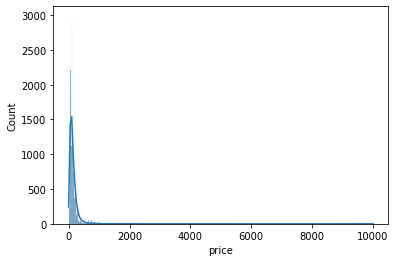

In [ ]:
# histogram of the target variable
sns.histplot(data=df, x='price', kde=True)

<Axes: ylabel='price'>

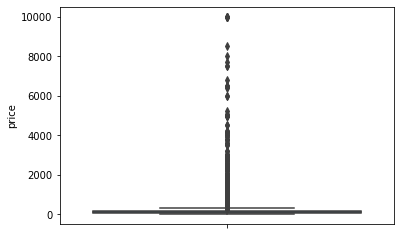

In [ ]:
# boxplot of the target variable
sns.boxplot(data=df, y='price')

<Axes: xlabel='neighbourhood_group', ylabel='price'>

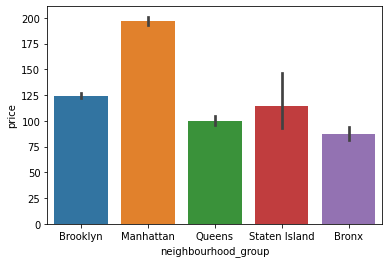

In [ ]:
# barplot of categorical variable (neighbourhood group)
sns.barplot(data=df, y='price', x='neighbourhood_group')

<Axes: xlabel='room_type', ylabel='price'>

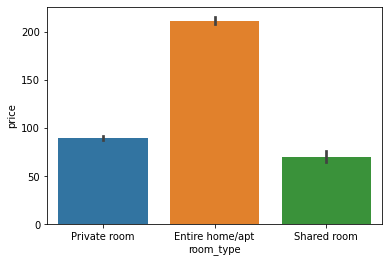

In [ ]:
# barplot of categorical variable (room type)
sns.barplot(data=df, y='price', x='room_type')

<ipython-input-15-4d0702d50c86>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['minimum_nights'], rug=False, kde=False, color="green", ax = axes)


Text(0, 0.5, 'count')

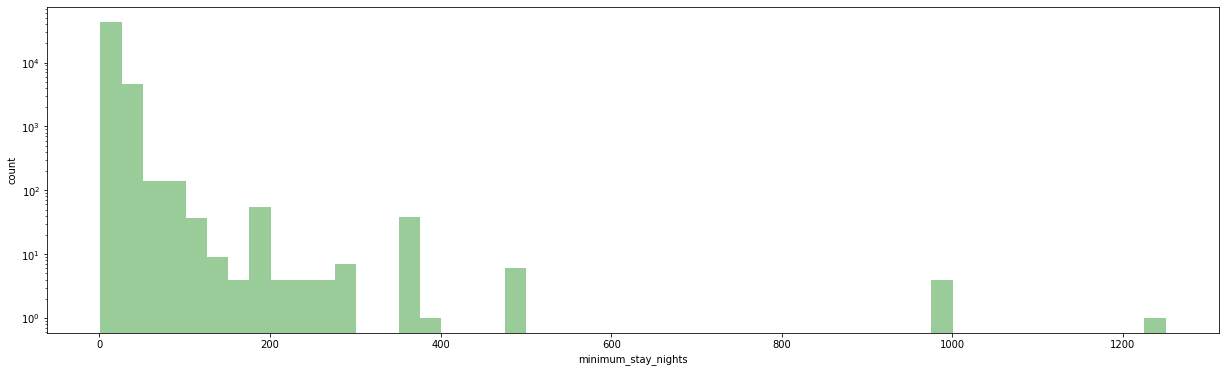

In [ ]:
# distribution of minimum nights
fig, axes = plt.subplots(figsize=(21, 6))

sns.distplot(df['minimum_nights'], rug=False, kde=False, color="green", ax = axes)
axes.set_yscale('log')
axes.set_xlabel('minimum_stay_nights')
axes.set_ylabel('count')

<Axes: ylabel='minimum_nights'>

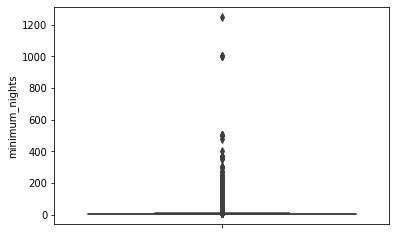

In [ ]:
# boxplot of minimum nights
sns.boxplot(data=df, y='minimum_nights')

<ipython-input-17-8adb3134e6b7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['availability_365'], rug=False, kde=False, color="blue", ax=axes)


(0.0, 365.0)

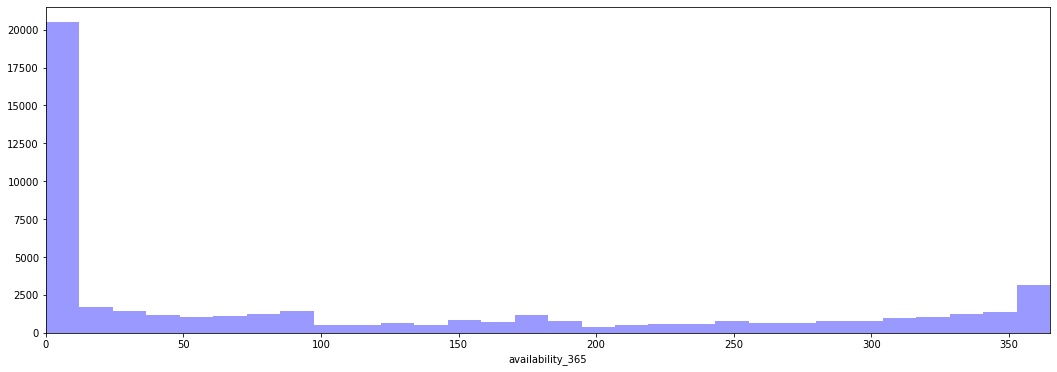

In [ ]:
# distribution of availability
fig, axes = plt.subplots(figsize=(18, 6))
sns.distplot(df['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

<Axes: >

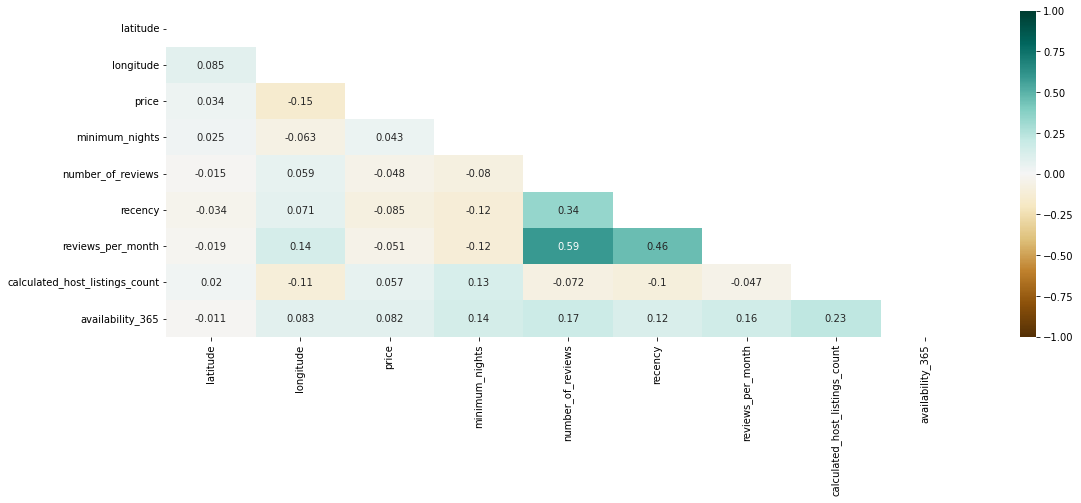

In [ ]:
# correlation matrix
plt.figure(figsize=(18,6))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask = np.triu(np.ones_like(df.corr(), dtype=bool)))

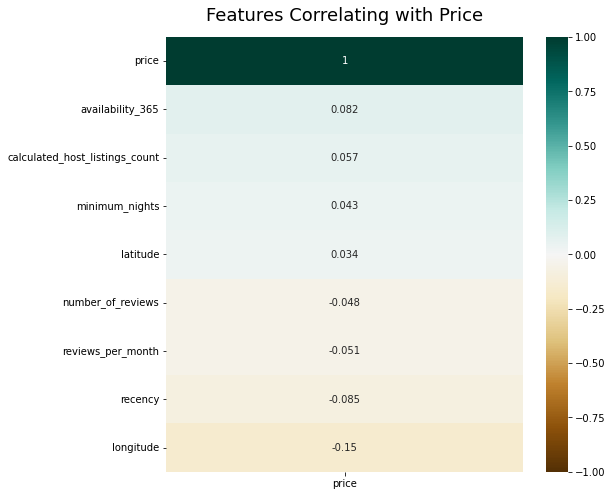

In [ ]:
# plotting correlation matrix with target variable
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

**Pre-processing**

In [ ]:
# encoding all categorical variables
df = pd.get_dummies(data=df, columns=['neighbourhood_group', 'neighbourhood','room_type'])

In [ ]:
# creating a new feature based on single and multi listing
df['multi_listing'] = np.where(df['calculated_host_listings_count']==1, 0, 1)
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,recency,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,multi_listing
0,40.64749,-73.97237,149,1,9,2762,0.21,6,365,0,...,0,0,0,0,0,0,0,1,0,1
1,40.75362,-73.98377,225,1,45,2976,0.38,2,355,0,...,0,0,0,0,0,0,1,0,0,1
2,40.80902,-73.94190,150,3,0,0,0.00,1,365,0,...,0,0,0,0,0,0,0,1,0,0
3,40.68514,-73.95976,89,1,270,3021,4.64,1,194,0,...,0,0,0,0,0,0,1,0,0,0
4,40.79851,-73.94399,80,10,9,2793,0.10,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# given the distribution of the availability, we split into three main buckets and encode
df.loc[df['availability_365'].between(0, 29, 'both'), 'Cat_available'] = 'Low_Avail'
df.loc[df['availability_365'].between(30, 300, 'both'), 'Cat_available'] = 'Med_Avail'
df.loc[df['availability_365'].between(301, 365, 'both'), 'Cat_available'] = 'All_year'

df = pd.get_dummies(data=df, columns=['Cat_available'])

In [ ]:
# dropping encoded column
df = df.drop(['availability_365'], axis=1)

In [ ]:
# creating a new column for short stay (less than 30days) and long stay (greater than 30 days)
df["rentals"] = np.where(df['minimum_nights'] < 30, 1, 0)

In [ ]:
# logging the target variable to make it less susceptible to the effect of the outliers
df = df[np.log1p(df['price']) < 8]
df = df[np.log1p(df['price']) > 3]

In [ ]:
df['price'] = np.log1p(df['price'])

<ipython-input-26-9fbd8f107ee1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = np.log1p(df['price'])


In [ ]:
# creating X and Y dataframes
y = df['price']
X = df.loc[:, df.columns!="price"]

In [ ]:
# dimensionality reduction for faster computation time
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA

PCA_df = PCA(n_components=0.90, random_state=2020)
X_pca = PCA_df.fit_transform(X_scaled)

X_reduced = pd.DataFrame(X_pca)

X_reduced

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,-2.081566,-1.189251,0.657610,1.253389,1.500271,0.512646,-1.499741,-1.172925,-0.277494,1.263634,...,-0.001265,0.017579,-0.016511,0.012418,-0.035020,0.030527,-0.021519,0.024473,0.025378,-0.011860
1,1.992167,0.510499,1.486188,0.737824,0.144585,-0.427429,-0.095573,-0.943786,1.548534,0.348962,...,0.000758,-0.001741,0.000560,-0.001616,0.005257,-0.001231,0.002761,-0.001821,0.003137,-0.002865
2,1.773447,1.265168,-1.290862,0.421025,1.004040,1.295128,-1.805507,0.150346,1.010785,-0.501991,...,-0.001446,0.004105,-0.000044,0.001411,0.000905,-0.000343,0.001709,-0.001140,-0.000301,0.001282
3,-2.186299,-0.211782,3.123429,-2.904747,-1.313397,-2.220981,0.467080,-0.061251,0.372311,-0.585888,...,0.004362,-0.003633,-0.000623,-0.010722,-0.001689,0.000512,0.000108,0.004376,0.015149,0.012676
4,2.213436,0.210778,-1.191760,-1.006788,-0.874009,-0.114507,0.289561,-0.008167,1.214472,-0.561363,...,-0.001746,0.008696,-0.002062,0.004138,0.004646,-0.002965,0.001291,-0.002355,-0.002660,0.005651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48779,-1.718797,-1.541700,-1.383066,0.877133,1.116357,0.618988,-1.204425,-0.177648,0.001384,-0.166265,...,-0.000348,0.002213,-0.001663,-0.001231,0.001589,0.000205,0.000810,-0.000574,0.000055,0.001277
48780,-1.983123,-0.427900,-0.331962,0.830840,1.371417,0.282754,-1.628365,1.046384,-0.568542,-0.165698,...,0.002032,0.002896,-0.004865,-0.000657,-0.001063,0.001108,0.001367,0.002777,0.006099,0.002831
48781,2.725681,0.017866,-1.934477,-0.316805,-0.462401,0.237530,0.196786,0.672174,0.696815,-0.942399,...,-0.002439,0.006033,-0.001906,0.000987,0.001025,-0.000307,0.001767,-0.001550,-0.000913,0.000250
48782,2.133556,-0.121561,-0.764863,0.656961,0.581577,0.872481,-0.818776,-1.634100,1.674146,3.562268,...,-0.001427,0.001454,-0.001020,-0.001877,0.005426,-0.000642,0.001961,-0.002504,-0.003768,-0.001270


In [ ]:
# train and test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state = 42)

print(f"Shape of X_train dataset: {X_train.shape}")
print(f"Shape of y_train dataset: {y_train.shape}")
print(f"Shape of X_test dataset: {X_test.shape}")
print(f"Shape of y_test dataset: {y_test.shape}")

Shape of X_train dataset: (39027, 204)
Shape of y_train dataset: (39027,)
Shape of X_test dataset: (9757, 204)
Shape of y_test dataset: (9757,)


**Elastic Net Base Model**

Note that all models hyperparameters have been optimized using GridSearchCV and the best_params_ have been selected for the final output.

For reporting model metrics, we use the R^2 and the mean absolute percentage error. The higher the R^2, the better the model, the closer the MAPE to zero the better the model.

Also, we reported the metrics on both the logged and anti-logged prediction.

In [ ]:
baseline_eNet = ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=4000, tol=0.001)

baseline_eNet.fit(X_train, y_train)

y_pred = baseline_eNet.predict(X_test)

# anti-logged prediction results
print((mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))))
print(r2_score(np.exp(y_test),np.exp(y_pred)))

# logged prediction results
print((mean_absolute_percentage_error(y_test,y_pred)))
print(r2_score(y_test, y_pred))

0.35612576738647167
0.20950620067135994
0.07319823009583386
0.5187193671064779


**Decision Tree Base Model**

In [31]:
baseline_dt = DecisionTreeRegressor(criterion='squared_error', max_depth=12,
                           max_features='sqrt', min_samples_leaf=10,
                           splitter='best')

baseline_dt.fit(X_train, y_train)

y_pred = baseline_dt.predict(X_test)

# anti-logged prediction results
print((mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))))
print(r2_score(np.exp(y_test),np.exp(y_pred)))

# logged prediction results
print((mean_absolute_percentage_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

0.3845994913547983
0.2272044210685913
0.07668522768088194
0.4711639303280222


**Random Forest Base Model**

In [32]:
baseline_rf = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=30,
                                    max_features='sqrt', min_samples_leaf=5, min_samples_split=5,
                                    n_estimators=500, n_jobs=None, random_state=42, warm_start=False)

baseline_rf.fit(X_train,y_train)

y_pred = baseline_rf.predict(X_test)

# anti-logged prediction results
print((mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))))
print(r2_score(np.exp(y_test),np.exp(y_pred)))

# logged prediction results
print((mean_absolute_percentage_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

0.33138094071218194
0.303092496321966
0.06729761157204507
0.5840342438437413


**Boosting Models**

**XGBoost Baseline Model**

In [33]:
baseline_XGB = XGBRegressor(n_estimators=500, 
                           learning_rate=0.05, 
                           colsample_bytree=0.7, 
                           max_depth=6, min_child_weight=1)

baseline_XGB.fit(X_train, y_train)

y_pred = baseline_XGB.predict(X_test)

# anti-logged prediction results
print((mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))))
print(r2_score(np.exp(y_test),np.exp(y_pred)))

# logged prediction results
print((mean_absolute_percentage_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

0.3261067563655481
0.29380417605590603
0.06671866051109689
0.5897205075901409
